In [2]:
import sys
sys.path.append('/mnt/pfs/akash.mishra/ppe_model/')
import numpy as np
import matplotlib.pyplot as plt
import waveform_model
# import pycbc.ppe.ppe_tools as ppe_tools

import pycbc
import bilby
import numpy as np
import matplotlib.pylab as plt
import pycbc.psd
from waveform_model import ppe_c1_eps_model
np.set_printoptions(threshold=sys.maxsize)
import pycbc.waveform as wf
from prior import DiscreteUniform

In [18]:
frequency_array = np.arange(20, 1024, 1/4)
mass_2 = 32
mass_1 = 35
luminosity_distance = 400
theta_jn = 0.5
phase = 0.5
# b = -1
# beta = 0.5
# delta_eps = 0

hp = waveform_model.ppe_c1_eps_model(frequency_array, mass_1, mass_2, luminosity_distance, theta_jn, phase, b, beta, delta_eps,
                     a=0.0, alpha=0.0, a_1=0.0, a_2=0.0, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

hc = waveform_model.ppe_c1_eps_model(frequency_array, mass_1, mass_2, luminosity_distance, theta_jn, phase, b, beta, delta_eps,
                     a=0.0, alpha=0.0, a_1=0.0, a_2=0.0, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['cross']

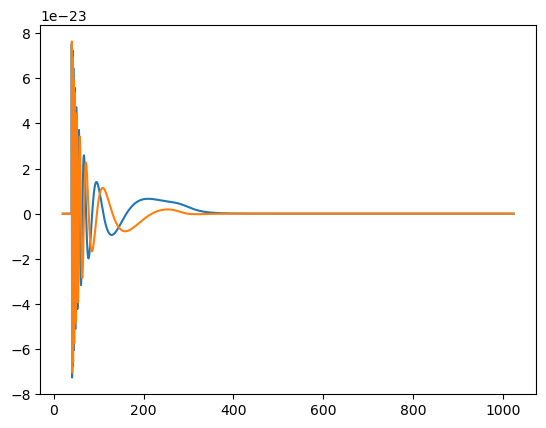

In [19]:
plt.plot(frequency_array, hp)
plt.plot(frequency_array, hc)

# Mismatch Analysis

In [2]:
waveform_arguments = dict(waveform_approximant='IMRPhenomD',reference_frequency=50., minimum_frequency=20.)
sampling_frequency=2048
duration=8

delta_f = 1/8
fhigh = 1024
flen = int(fhigh/delta_f) +1
flow = 20

In [6]:
asd_file_HL='/mnt/pfs/akash.mishra/ppe_model/Noise/aLIGO_O4_high_asd.txt'
psd_HL = pycbc.psd.from_txt(asd_file_HL, flen, delta_f,flow, is_asd_file=True)

psd_file_V='/mnt/pfs/akash.mishra/ppe_model/Noise/AdV_psd.txt'
psd_V = pycbc.psd.from_txt(psd_file_V, flen, delta_f,flow, is_asd_file=False)

gauss_noise_injection = False

In [18]:
waveform_generator_gr = bilby.gw.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,waveform_arguments=waveform_arguments)

waveform_generator_ppe = bilby.gw.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=ppe_c1_eps_model,parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,waveform_arguments=waveform_arguments)

18:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveform_model.ppe_c1_eps_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [20]:
GW150914_injection_parameters=dict(mass_1 = 38.3, mass_2 = 33.19, luminosity_distance = 558.553, dec = -1.223, ra = 2.269,theta_jn = 2.921, chi_1 = 0.3, chi_2 = 0.27, psi = 1.575, phase = 1.893,geocent_time = 1126259462.414)

hp = waveform_generator_gr.frequency_domain_strain(parameters=GW150914_injection_parameters)['plus']
hc = waveform_generator_gr.frequency_domain_strain(parameters=GW150914_injection_parameters)['cross']

In [67]:
ppe_bilby_params= GW150914_injection_parameters.copy()
ppe_bilby_params['delta_eps'] =-2
ppe_bilby_params['alpha'] = 0
ppe_bilby_params['a'] = 0
ppe_bilby_params['delta_f'] =delta_f
ppe_bilby_params['f_lower'] =flow
ppe_bilby_params['reference_frequency'] = 50.0
ppe_bilby_params['minimum_frequency'] = ppe_bilby_params['f_lower']
ppe_params['delta_eps'] = -2
ppe_params['b'] = -1
ppe_params['beta'] = -20
ppe_bilby_params['a'] = 0

hp_ppe = waveform_generator_ppe.frequency_domain_strain(ppe_bilby_params)['plus']
hc_ppe = waveform_generator_ppe.frequency_domain_strain(ppe_bilby_params)['cross']

(10.0, 512.0)

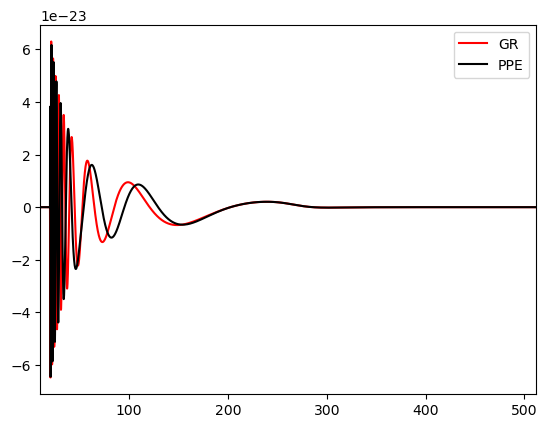

In [68]:
plt.plot(waveform_generator_gr.frequency_array, hp, label = 'GR', color = 'red')
plt.plot(waveform_generator_ppe.frequency_array, hp_ppe, label = 'PPE', color = 'black')
plt.legend()
plt.xlim([10, 512])

In [69]:
gr_pols = waveform_generator_gr.time_domain_strain(parameters=GW150914_injection_parameters)
ppe_pols = waveform_generator_ppe.time_domain_strain(parameters=ppe_bilby_params)
x = waveform_generator_gr.time_array

In [72]:
def plot_gr_ppe_comparisons(gr_parameters, ppe_bilby_params, domain = ['time','frequency']):
    if 'time' in domain:
        plot_td_gr_ppe(gr_parameters, ppe_bilby_params)
    if 'frequency' in domain:
        plot_fd_gr_ppe(gr_parameters, ppe_bilby_params)
        
    
def plot_td_gr_ppe(gr_parameters, ppe_bilby_params):
    gr_pols = waveform_generator_gr.time_domain_strain(parameters=gr_parameters)
    ppe_S_pols = waveform_generator_ppe.time_domain_strain(parameters=ppe_bilby_params)
    x = waveform_generator_gr.time_array
    
    
    plot_strain_series([x,x], [gr_pols, ppe_S_pols], ['GR', 'PPE_S'], 'time(s)', (7.5,8.0), ppe_bilby_params)
    
def plot_fd_gr_ppe(gr_parameters, ppe_bilby_params):
    gr_fd_pols = waveform_generator_gr.frequency_domain_strain(parameters=gr_parameters)
    ppe_fd_S_pols = waveform_generator_ppe.frequency_domain_strain(parameters=ppe_bilby_params)
    
    x = waveform_generator_gr.frequency_array
    plot_strain_series([x,x], [gr_fd_pols, ppe_fd_S_pols], ['GR', 'PPE_S'], 'frequency(Hz)', (flow-5,200), ppe_bilby_params)
    

def plot_strain_series(x_arr, pols_arr, pols_label_arr, xlabel, xlim, ppe_params,xscale_log=False):
    beta = ppe_params['beta']
    b = ppe_params['b']
    delta_eps = ppe_params['delta_eps']
    
    color_arr = ['b-','r','g--']
    lw_arr =[0.5, 0.9, 0.9]
    fig, ax = plt.subplots(1, 2,figsize=(15, 5))
    fig.suptitle('Beta = '+ str(beta) + ', b = ' + str(b) + ', delta_eps = ' + str(delta_eps), fontsize=16)
    
    for i in range(len(pols_arr)):
        ax[0].plot(x_arr[i], pols_arr[i]['plus'], color_arr[i], lw=lw_arr[i],label=pols_label_arr[i] + ' +')
        ax[1].plot(x_arr[i], pols_arr[i]['cross'], color_arr[i], lw=lw_arr[i],label=pols_label_arr[i] + ' x')

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('strain')
    ax[0].set_xlim(xlim)
    if xscale_log==True:
        ax[0].set_xscale('log')
    ax[0].legend()

    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('strain')
    ax[1].set_xlim(xlim)
    if xscale_log==True:
        ax[1].set_xscale('log')
    

    ax[1].legend()

    plt.tight_layout()
    plt.show()

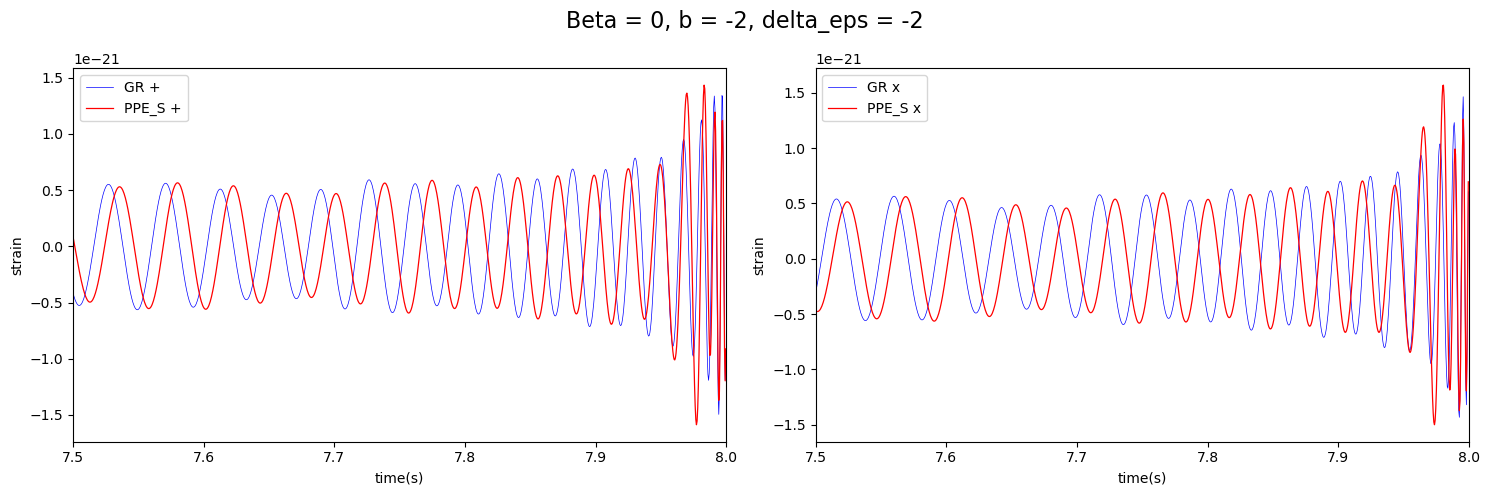

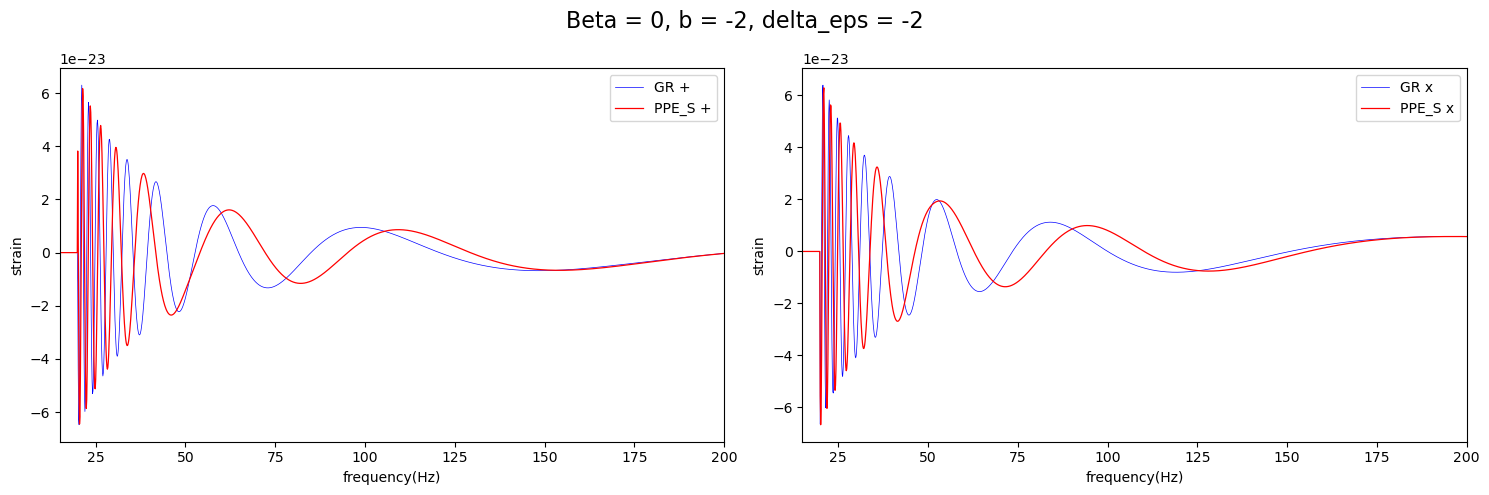

In [73]:
plot_gr_ppe_comparisons(GW150914_injection_parameters, ppe_bilby_params, domain=['time','frequency'])

# GR Injection

In [3]:
import bilby
import numpy as np
from waveform_model import ppe_c1_eps_model

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.0
sampling_frequency = 1024.0

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "full_15_parameters"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

In [4]:
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    a = 0.0,
    alpha = 0.0,
    b = -3,
    beta = 0.1,
    delta_eps = -0.2,
)
# injection_parameters = dict(
#     mass_1=36.0,
#     mass_2=29.0,
#     a_1=0.4,
#     a_2=0.3,
#     tilt_1=0.5,
#     tilt_2=1.0,
#     phi_12=1.7,
#     phi_jl=0.3,
#     luminosity_distance=2000.0,
#     theta_jn=0.4,
#     psi=2.659,
#     phase=1.3,
#     geocent_time=1126259642.413,
#     ra=1.375,
#     dec=-1.2108,

# )


In [5]:
waveform_arguments = dict(
    waveform_approximant="IMRPhenomXPHM",
    reference_frequency=50.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=ppe_c1_eps_model,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)


14:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveform_model.ppe_c1_eps_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [6]:
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)

ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

# For this analysis, we implement the standard BBH priors defined, except for
# the definition of the time prior, which is defined as uniform about the
# injected value.
# We change the mass boundaries to be more targeted for the source we
# injected.
# We define priors in the time at the Hanford interferometer and two
# parameters (zenith, azimuth) defining the sky position wrt the two
# interferometers.

14:44 bilby INFO    : Injected signal in H1:
14:44 bilby INFO    :   optimal SNR = 11.78
14:44 bilby INFO    :   matched filter SNR = 10.48-0.28j
14:44 bilby INFO    :   mass_1 = 36.0
14:44 bilby INFO    :   mass_2 = 29.0
14:44 bilby INFO    :   a_1 = 0.4
14:44 bilby INFO    :   a_2 = 0.3
14:44 bilby INFO    :   tilt_1 = 0.5
14:44 bilby INFO    :   tilt_2 = 1.0
14:44 bilby INFO    :   phi_12 = 1.7
14:44 bilby INFO    :   phi_jl = 0.3
14:44 bilby INFO    :   luminosity_distance = 2000.0
14:44 bilby INFO    :   theta_jn = 0.4
14:44 bilby INFO    :   psi = 2.659
14:44 bilby INFO    :   phase = 1.3
14:44 bilby INFO    :   geocent_time = 1126259642.413
14:44 bilby INFO    :   ra = 1.375
14:44 bilby INFO    :   dec = -1.2108
14:44 bilby INFO    :   a = 0.0
14:44 bilby INFO    :   alpha = 0.0
14:44 bilby INFO    :   b = -3
14:44 bilby INFO    :   beta = 0.1
14:44 bilby INFO    :   delta_eps = -0.2
14:44 bilby INFO    : Injected signal in L1:
14:44 bilby INFO    :   optimal SNR = 9.53
14:44 bi

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         -0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
         -0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         -0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
         -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
          0.00000

In [7]:
priors = bilby.gw.prior.BBHPriorDict()
# time_delay = ifos[0].time_delay_from_geocenter(
#     injection_parameters["ra"],
#     injection_parameters["dec"],
#     injection_parameters["geocent_time"],
# )
priors["geocent_time"] = bilby.core.prior.Uniform(
    minimum=injection_parameters["geocent_time"] - 0.1,
    maximum=injection_parameters["geocent_time"] + 0.1,
    name="geocent_time",
    latex_label="$t_c$",
    unit="$s$",
)

# del priors["ra"], priors["dec"] #, priors["chirp_mass"], priors["mass_ratio"]
# priors["zenith"] = bilby.core.prior.Sine(latex_label="$\\kappa$")
# priors["azimuth"] = bilby.core.prior.Uniform(
#     minimum=0, maximum=2 * np.pi, latex_label="$\\epsilon$", boundary="periodic"
# )

#del priors["chirp_mass"], priors["mass_ratio"]

priors['alpha'] = 0.0
priors['a'] = 0.0
#priors['b'] = -5
# priors['beta'] = 0.0
# priors['delta_eps'] = 0.0
### ppe recovery
priors['b']=DiscreteUniform(-7,1,name='b', latex_label='$b$')
priors['beta']=bilby.prior.Uniform(-5.0,5.0,name='beta', latex_label='$\beta$')
priors['delta_eps']=bilby.prior.Uniform(-5,5,name='delta_eps', latex_label='$\delta$')

14:44 bilby INFO    : No prior given, using default BBH priors in /home/akash.mishra/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [8]:
priors

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None),
 'ra': Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic'),
 'the

In [9]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveoform generator, as well the priors.
# The explicit distance marginalization is turned on to improve
# convergence, and the posterior is recovered by the conversion function.
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
    distance_marginalization=False,
    phase_marginalization=False,
    time_marginalization=False,

)

In [ ]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1000,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    
)


14:45 bilby INFO    : Running for label 'full_15_parameters', output will be saved to 'outdir'
14:45 bilby INFO    : Using lal version 7.2.4
14:45 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.2.4;Id: e5e51f77cbaf264a20a620b4acefbe7ac38c84c6;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:45 bilby INFO    : Using lalsimulation version 4.0.2
14:45 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v4.0.2;Id: 233cc3963d87688c272b7affe7dd0b962e4c11a0;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:45 bilby INFO    : Search parameters:
14:45 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
14:45 bilby INFO    :   chirp_mass = Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
14:45 bilby INFO    :   lumi

0it [00:00, ?it/s]

14:45 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fe4b31a1bb0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
14:45 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:45 bilby INFO    : Using dynesty version 1.0.1
14:45 bilby INFO    : Using the bi

In [43]:
len(priors), len(injection_parameters)

(22, 20)